In [1]:
import glob
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import shapely
import matplotlib.colors as colors
from IPython.display import clear_output
from tqdm.notebook import tqdm
import time
from IPython.core.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\rmpjazz\AppData\Local\Temp\ipykernel_43732\1679906244.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
####### IMPORT DATA
cell_geo = pd.read_pickle("./dataframes/cell_geometry")
cell = geopandas.GeoDataFrame(cell_geo, columns=['geometry'], 
                                 crs='epsg:4326')

jsonfile = ('./ark28722-s73w23-geojson.json')
world = geopandas.read_file(jsonfile)

fires = pd.read_pickle("./dataframes/all_fires")
fires = fires[~fires["GIS_ACRES"].isnull()]
fires = fires[~fires.duplicated()]
fires = fires[~fires[["FIRE_NAME", "INC_NUM", "ALARM_DATE", "CONT_DATE", "CAUSE", "geometry"]].duplicated()]

fires = fires.loc[(fires["YEAR"] >= 2000) & (fires["YEAR"] <= 2019) & (fires["MONTH"] >= 6) & (fires["MONTH"] <= 10)]

<Axes: >

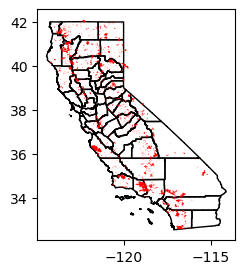

In [3]:
ax = world.to_crs(cell.crs).plot(color = "none", edgecolor = 'black', figsize = (5,3))
fires.plot(ax = ax, color = "red")

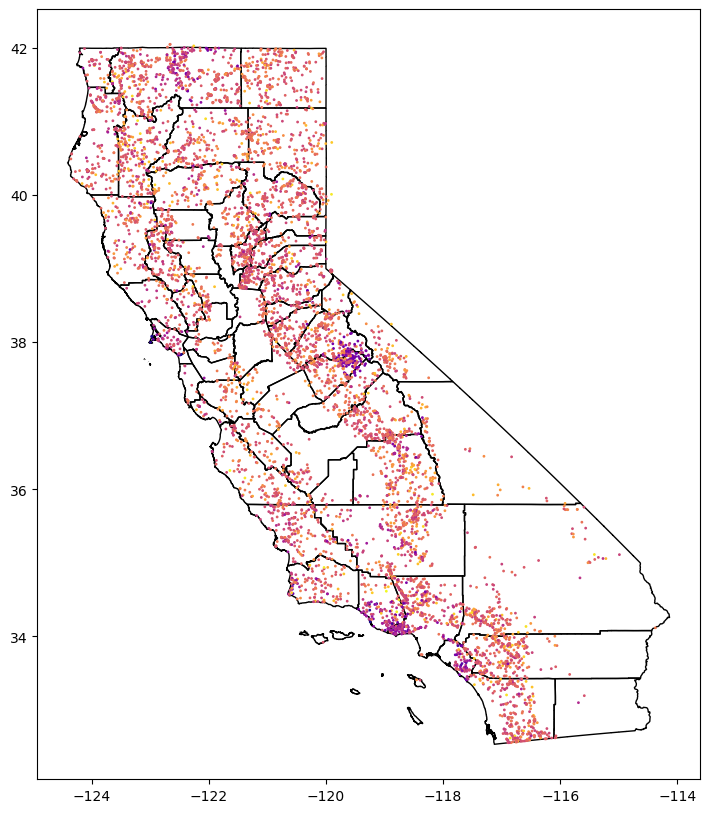

In [9]:
ax = world.to_crs(cell.crs).plot(color = "none", edgecolor = 'black', figsize = (10,10))
plt.scatter(pointsx, pointsy, cmap = "plasma", c=np.log(values), s= 1)

In [4]:
pointsx = np.array(fires["geometry"].centroid.x)
pointsy = np.array(fires["geometry"].centroid.y)
values = np.array(fires["GIS_ACRES"])
xi = np.array(cell["geometry"].centroid.x)
yi = np.array(cell["geometry"].centroid.y)

C:\Users\rmpjazz\AppData\Local\Temp\ipykernel_43732\460736680.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pointsx = np.array(fires["geometry"].centroid.x)
C:\Users\rmpjazz\AppData\Local\Temp\ipykernel_43732\460736680.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pointsy = np.array(fires["geometry"].centroid.y)
C:\Users\rmpjazz\AppData\Local\Temp\ipykernel_43732\460736680.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xi = np.array(cell["geometry"].centroid.x)
C:\Users\rmpjazz\AppData\Local\Temp\ipykernel_43732\460736680.py:5: UserWarning: Geometry is i

In [8]:
from scipy.interpolate import griddata
cell["interpolated_value"] = griddata(np.array([pointsx, pointsy]).T, values, np.array([xi, yi]).T, method='linear')
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/linear_interpolation_normal")

In [21]:
from scipy.interpolate import griddata
cell["interpolated_value"] = griddata(np.array([pointsx, pointsy]).T, np.log(values*10000), np.array([xi, yi]).T, method='linear')
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/linear_interpolation_log_shifted10000")

In [22]:
from scipy.interpolate import griddata
cell["interpolated_value"] = griddata(np.array([pointsx, pointsy]).T, np.log(values*10000), np.array([xi, yi]).T, method='nearest')
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/nearest_interpolation_log_shifted10000")

In [9]:
len(fires)

7234

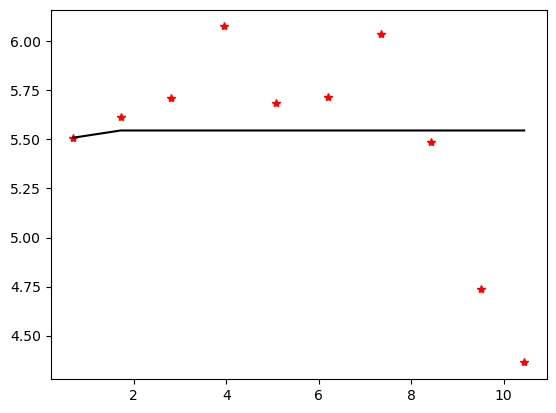

In [10]:
OK = OrdinaryKriging(
    pointsx,
    pointsy,
    np.log(values),
    variogram_model='gaussian',
    enable_plotting=True,
    coordinates_type="geographic",
    nlags=10,
)

In [11]:
interpolated_values, stdsq = OK.execute("points", xi, yi)

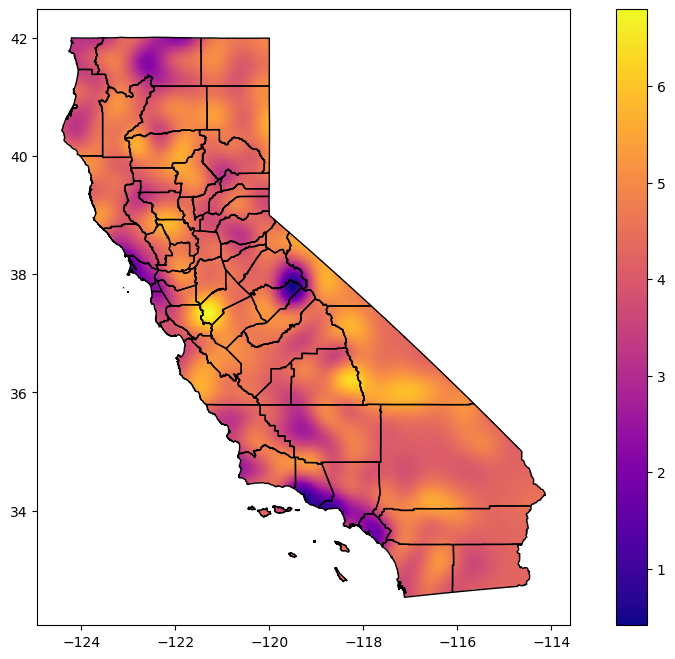

In [12]:
import matplotlib.colors as colors

def plotter(dataset):
    cell["interpolated_value"] = dataset
    ax = cell.plot(column='interpolated_value', figsize=(12, 8), cmap='plasma', legend=True)
    world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (12,8))
plotter(interpolated_values)

In [13]:
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/ordinary_kriging_gaussian_geographic_nlags_10_values")

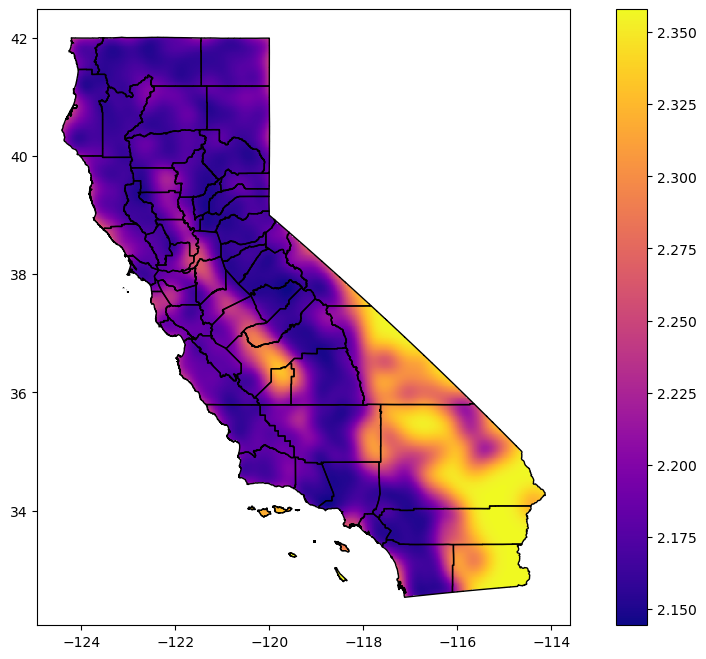

In [14]:
plotter(np.sqrt(stdsq))

In [15]:
cell["interpolated_value"].to_pickle("./dataframes/2000-2019/ordinary_kriging_gaussian_geographic_nlags_10_std")

In [19]:
min(values)*10000

12.49078894034028